### research paper -->  https://arxiv.org/pdf/1907.10902

#### Bayesian Optimization (TPE) paper --->  https://arxiv.org/pdf/2304.11127

# Optuna: Deep Theoretical Dive and Implementation Guide

## 1. Theoretical Foundation of Bayesian Optimization in Optuna

### 1.1 Bayesian Optimization Framework

Bayesian optimization is a sequential design strategy for global optimization of black-box functions. It works on two key principles:

1. **Surrogate Model**: A probabilistic model that approximates the objective function and quantifies uncertainty in regions where observations are sparse.

2. **Acquisition Function**: A utility function that guides the search process by determining which points to evaluate next, balancing exploration and exploitation.

In Optuna, this framework is implemented primarily through the Tree-structured Parzen Estimator (TPE) algorithm.

### 1.2 Mathematical Details of TPE

The TPE approach models the conditional probability distribution p(x|y) rather than the more common approach of modeling p(y|x), where:
- x represents hyperparameters
- y represents the objective function value

TPE divides the observed hyperparameters into two groups:
- **l(x)**: Density of hyperparameters x when y is less than some threshold y* (good performers)
- **g(x)**: Density of hyperparameters x when y is greater than the threshold y* (poor performers)

The threshold y* is typically set to some quantile γ of the observed values (default γ=0.25).

The next set of hyperparameters to evaluate is chosen by maximizing the improvement function:

$EI(x) = \frac{l(x)}{g(x)} \cdot (γ - \frac{l(x)}{l(x) + g(x)})$

This leads to a balance between:
- Selecting points where l(x) is high (exploitation)
- Avoiding points where g(x) is high (exploration)

### 1.3 Kernel Density Estimation in TPE

The densities l(x) and g(x) are modeled using kernel density estimation (KDE):

$p(x) = \frac{1}{nh} \sum_{i=1}^{n} K(\frac{x - x_i}{h})$

Where:
- K is a kernel function (typically Gaussian)
- h is the bandwidth parameter
- x_i are observed hyperparameters

TPE uses a tree-structured approach for the KDE, allowing it to handle:
- Different variable types (continuous, discrete, categorical)
- Conditional parameter spaces
- Parameter dependencies

## 2. The Optuna Architecture: Core Components

### 2.1 Study and Trial Organization

Optuna's architecture consists of several key abstractions:

```
Study
  ├── Trials (multiple)
  │     ├── Trial Parameters
  │     └── Trial Value (objective function result)
  ├── Sampler (TPE, Random, etc.)
  ├── Pruner (optional)
  └── Storage Backend (optional)
```

### 2.2 Parameter Search Space Definition

Optuna allows dynamic definition of search spaces through its "define-by-run" API:

- **Traditional frameworks (define-and-run)**:
  ```python
  # Define entire search space upfront
  param_grid = {
      'learning_rate': [0.001, 0.01, 0.1],
      'max_depth': [3, 5, 7],
      'min_child_weight': [1, 3, 5]
  }
  ```

- **Optuna approach (define-by-run)**:
  ```python
  def objective(trial):
      # Define parameters dynamically during execution
      params = {
          'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
          # Conditionally define more parameters based on previous suggestions
          'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
      }
      
      # Add parameters conditionally
      if params['booster'] == 'gbtree' or params['booster'] == 'dart':
          params['max_depth'] = trial.suggest_int('max_depth', 3, 9)
      
      # Return objective value
      return calculate_metric(params)
  ```

This dynamic approach enables conditional parameter spaces that adapt based on previous parameter choices.

### 2.3 Pruning Mechanisms

Optuna implements various pruning strategies to terminate unpromising trials early:

```python
def objective(trial):
    for epoch in range(100):
        # Train model for one epoch
        intermediate_value = evaluate_model()
        
        # Report intermediate value to Optuna
        trial.report(intermediate_value, epoch)
        
        # Check if trial should be pruned
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return final_score
```

Available pruners include:
- **MedianPruner**: Prunes if current trial's performance is worse than median of previous trials
- **PercentilePruner**: Prunes if performance is below a specified percentile of previous trials
- **SuccessiveHalvingPruner**: Allocates more resources to promising trials
- **HyperbandPruner**: Extension of SuccessiveHalving with multiple brackets

## 3. Advanced Implementation Patterns

### 3.1 Multi-Objective Optimization

Optimize multiple competing objectives simultaneously:

```python
def objective(trial):
    x = trial.suggest_float("x", 0, 5)
    y = trial.suggest_float("y", 0, 3)
    
    v0 = 4 * x ** 2 + 4 * y ** 2
    v1 = (x - 5) ** 2 + (y - 5) ** 2
    
    return v0, v1  # Return multiple objectives

study = optuna.create_study(directions=["minimize", "minimize"])
study.optimize(objective, n_trials=100)

# Get Pareto front
pareto_front = study.best_trials  # All non-dominated trials
```

### 3.2 Custom Samplers and Integration with External Algorithms

Create custom sampling strategies:

```python
class CustomSampler(optuna.samplers.BaseSampler):
    def __init__(self, seed=None):
        self.rng = numpy.random.RandomState(seed)
        
    def sample_relative(self, study, trial, search_space):
        result = {}
        for name, distribution in search_space.items():
            if isinstance(distribution, optuna.distributions.UniformDistribution):
                result[name] = self.rng.uniform(
                    distribution.low, distribution.high)
            # Handle other distribution types
        return result
        
    def sample_independent(self, study, trial, param_name, param_distribution):
        # Fallback method for parameters not in the relative sampling
        if isinstance(param_distribution, optuna.distributions.UniformDistribution):
            return self.rng.uniform(param_distribution.low, param_distribution.high)
        # Handle other distribution types

study = optuna.create_study(sampler=CustomSampler(seed=42))
```

### 3.3 Distributed Optimization

Run optimization across multiple workers:

```python
# Worker 1
study = optuna.create_study(
    study_name="distributed-example",
    storage="sqlite:///example.db",
    load_if_exists=True
)
study.optimize(objective, n_trials=100)

# Worker 2 (running simultaneously on another machine/process)
study = optuna.create_study(
    study_name="distributed-example",
    storage="sqlite:///example.db",
    load_if_exists=True
)
study.optimize(objective, n_trials=100)
```

### 3.4 Incorporating Domain Knowledge with Prior Distributions

Use prior knowledge to guide the sampling process:

```python
from optuna.samplers import TPESampler

# Create a sampler with custom prior distributions
sampler = TPESampler(
    seed=42,
    prior_weight=1.0,  # How strongly to weigh prior
    consider_magic_clip=True,
    consider_endpoints=True,
    n_startup_trials=10  # Random trials before using TPE
)

study = optuna.create_study(sampler=sampler)

def objective(trial):
    # Parameter with prior knowledge that values around 0.1 work well
    lr = trial.suggest_float('lr', 0.001, 0.5, log=True)
    # The rest of the objective function
    return evaluate_model(lr)

study.optimize(objective, n_trials=100)
```

## 4. Complete Workflow Examples

### 4.1 Hyperparameter Optimization for XGBoost with Pruning

```python
import optuna
import xgboost as xgb
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load data
data, target = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        # Use dynamic sampling to suggest hyperparameters
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }

    # Add a pruning callback
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, 'validation-error')
    
    # Train with early stopping and pruning
    history = xgb.cv(
        param, dtrain,
        num_boost_round=10000,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
        nfold=5,
        metrics=['error'],
        seed=42
    )
    
    # Extract the best score
    best_score = history['test-error-mean'].values[-1]
    
    return best_score

# Create a study with pruning
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=30)
study = optuna.create_study(
    direction='minimize',
    pruner=pruner,
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Optimize with 100 trials
study.optimize(objective, n_trials=100)

# Print results
print(f"Best trial: #{study.best_trial.number}")
print(f"Best value: {study.best_value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

# Train model with best parameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
model = xgb.train(best_params, dtrain)

# Evaluate on test set
y_pred = model.predict(dtest)
y_pred_binary = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Test accuracy: {accuracy:.4f}")

# Visualize optimization history
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)
optuna.visualization.plot_contour(study)
```

### 4.2 Multi-stage Optimization Pipeline

This example shows how to use Optuna for a multi-stage optimization pipeline, where coarse optimization is followed by fine-tuning:

```python
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Stage 1: Coarse optimization
def objective_stage1(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 500, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    score = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
    return score

# Create first study for coarse search
study_stage1 = optuna.create_study(direction='maximize')
study_stage1.optimize(objective_stage1, n_trials=30)

# Extract best parameters from first stage
best_n_estimators = study_stage1.best_params['n_estimators']
best_max_depth = study_stage1.best_params['max_depth']
best_min_samples_split = study_stage1.best_params['min_samples_split']

# Stage 2: Fine-tuning around the best parameters
def objective_stage2(trial):
    # Fine-tune around best parameters from stage 1
    n_estimators = trial.suggest_int('n_estimators',
                                     max(10, int(best_n_estimators * 0.8)),
                                     int(best_n_estimators * 1.2))
    
    max_depth = trial.suggest_int('max_depth',
                                 max(2, int(best_max_depth * 0.8)),
                                 int(best_max_depth * 1.2))
    
    min_samples_split = trial.suggest_int('min_samples_split',
                                         max(2, int(best_min_samples_split * 0.8)),
                                         int(best_min_samples_split * 1.2))
    
    # Add more fine-tuning parameters
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        criterion=criterion,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    score = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
    return score

# Create second study for fine-tuning
study_stage2 = optuna.create_study(direction='maximize')
study_stage2.optimize(objective_stage2, n_trials=50)

print("Stage 1 best parameters:")
print(study_stage1.best_params)
print(f"Stage 1 best value: {study_stage1.best_value:.4f}")

print("\nStage 2 best parameters:")
print(study_stage2.best_params)
print(f"Stage 2 best value: {study_stage2.best_value:.4f}")

# Comparison of improvement
improvement = (study_stage2.best_value - study_stage1.best_value) / study_stage1.best_value * 100
print(f"\nImprovement: {improvement:.2f}%")
```

### 4.3 Integration with Deep Learning Framework (PyTorch)

```python
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

def define_model(trial):
    # Dynamically define the network architecture
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    
    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_l{i}', 32, 256)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        
        # Optional dropout with probability
        dropout = trial.suggest_float(f'dropout_l{i}', 0.0, 0.5)
        if dropout > 0.0:
            layers.append(nn.Dropout(dropout))
            
        in_features = out_features
    
    # Output layer
    layers.append(nn.Linear(in_features, 10))
    layers.append(nn.LogSoftmax(dim=1))
    
    return nn.Sequential(*layers)

def objective(trial):
    # Generate model
    model = define_model(trial)
    
    # Generate optimizers
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSprop'])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    
    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.0, 0.99)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    
    # Data loading
    batch_size = trial.suggest_int('batch_size', 32, 512, log=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    n_epochs = 10
    for epoch in range(n_epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.view(-1, 28*28).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.view(-1, 28*28).to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        accuracy = correct / len(test_loader.dataset)
        
        # Report intermediate metric
        trial.report(accuracy, epoch)
        
        # Handle pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return accuracy

# Create a pruner
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)

# Create a study
study = optuna.create_study(
    direction='maximize',
    pruner=pruner,
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Optimize
study.optimize(objective, n_trials=100, timeout=3600)  # 1 hour timeout

# Print results
print(f"Best trial: #{study.best_trial.number}")
print(f"Best accuracy: {study.best_value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")
```

## 5. Visualization and Analysis of Optimization Results

Optuna provides built-in visualization tools to analyze optimization results:

```python
import optuna
import matplotlib.pyplot as plt

# Assuming we have already run a study
# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

# 1. Optimization history
plt.figure(figsize=(10, 6))
optimization_history_plot = optuna.visualization.plot_optimization_history(study)
optimization_history_plot.show()

# 2. Parameter importance
plt.figure(figsize=(10, 6))
param_importance_plot = optuna.visualization.plot_param_importances(study)
param_importance_plot.show()

# 3. Parameter relationships
plt.figure(figsize=(10, 6))
param_contour_plot = optuna.visualization.plot_contour(study, params=['learning_rate', 'max_depth'])
param_contour_plot.show()

# 4. Slice plot
plt.figure(figsize=(10, 6))
slice_plot = optuna.visualization.plot_slice(study)
slice_plot.show()

# 5. EDF (empirical distribution function) plot
plt.figure(figsize=(10, 6))
edf_plot = optuna.visualization.plot_edf(study)
edf_plot.show()

# 6. Parallel coordinate plot
plt.figure(figsize=(10, 6))
parallel_plot = optuna.visualization.plot_parallel_coordinate(study)
parallel_plot.show()

# 7. Intermediate values plot
plt.figure(figsize=(10, 6))
intermediate_plot = optuna.visualization.plot_intermediate_values(study)
intermediate_plot.show()
```

## 6. Comparison with Other Optimization Frameworks

| Feature | Optuna | Hyperopt | Scikit-learn CV | Ray Tune |
|---------|--------|----------|-----------------|----------|
| API Style | Define-by-run | Define-and-run | Define-and-run | Mixed |
| Default Algorithm | TPE | TPE | GridSearch/RandomSearch | Various |
| Pruning | Yes | Limited | No | Yes |
| Multi-objective | Yes | No | No | Yes |
| Parallel Execution | Yes | Yes | Yes | Yes |
| Visualization | Extensive | Limited | Limited | Extensive |
| Integration with ML Frameworks | Many | Several | Scikit-learn | Many |
| Database Backend | Yes | Limited | No | Yes |
| Active Community | Very active | Moderate | Very active | Active |
| Conditional Parameters | Yes | Yes | No | Yes |

## 7. Best Practices for Efficient Hyperparameter Optimization

1. **Start broad, then refine**:
   - Begin with a wide search space
   - Use log scales for parameters with large ranges
   - Refine promising regions in subsequent optimizations

2. **Design efficient objective functions**:
   - Use cross-validation for stability
   - Implement early stopping where possible
   - Consider using lower fidelity evaluations for initial screening

3. **Leverage pruning effectively**:
   - Report intermediate values frequently
   - Use appropriate pruners for your problem
   - Set reasonable warmup periods

4. **Utilize appropriate computational resources**:
   - Distribute optimization when possible
   - Persist studies to allow resuming
   - Consider resource-aware optimization

5. **Analyze results thoroughly**:
   - Examine parameter importances
   - Look for parameter interactions
   - Consider multiple metrics when relevant

6. **Define search spaces thoughtfully**:
   - Use domain knowledge to constrain ranges
   - Consider dependencies between parameters
   - Use appropriate distributions (log-uniform for learning rates, etc.)

### **Optuna & TPE: Comprehensive Guide for Beginners**

---

#### **1. What is Optuna?**
**Optuna** is an open-source hyperparameter optimization (HPO) framework designed to automate the search for the best parameters of machine learning models. It is built with flexibility and scalability in mind, making it suitable for both small experiments and large-scale distributed computations. Unlike traditional methods like Grid Search or Random Search, Optuna uses advanced techniques like Bayesian optimization to efficiently navigate the parameter space.

---

#### **2. Key Features of Optuna**
1. **Define-by-Run API**:
   - **What it means**: Instead of predefining the search space upfront (like Hyperopt), Optuna lets you dynamically construct the parameter space *during the optimization process*. This is done using Python code inside the **objective function**.
   - **Example**:  
     ```python
     def objective(trial):
         n_layers = trial.suggest_int("n_layers", 1, 5)  # Dynamically suggest layers
         layers = []
         for i in range(n_layers):
             layers.append(trial.suggest_int(f"units_layer_{i}", 32, 256))  # Dynamic units per layer
         return train_model(layers)
     ```
   - **Advantage**: Flexibility to handle conditional parameters (e.g., if using a dropout layer, include its rate) and complex search spaces.

2. **Efficient Sampling Algorithms**:
   - Supports samplers like **TPE (Tree-structured Parzen Estimator)**, CMA-ES, and Random Search.
   - Balances **exploration** (trying new regions) and **exploitation** (focusing on known good regions).

3. **Pruning (Early Stopping)**:
   - Automatically stops unpromising trials to save computational resources.
   - Example: **ASHA (Asynchronous Successive Halving Algorithm)** stops poorly performing trials early based on intermediate results.

4. **Distributed Optimization**:
   - Scales horizontally across multiple machines/GPUs using backends like SQLite or Redis.
   - **Example**: Run 10 workers in parallel to speed up optimization.

5. **Visualization & Dashboard**:
   - Provides real-time visualization of trials, parameter importance, and learning curves.

---

#### **3. What is TPE (Tree-structured Parzen Estimator)?**
TPE is a **Bayesian optimization** algorithm used to efficiently search hyperparameters. It works by:
1. **Splitting Trials**:
   - Divides past trials into two groups: **top-performing (γ-quantile)** and **bottom-performing**.
   - Example: If γ=0.2, the top 20% of trials are used to model "good" hyperparameters.

2. **Modeling Distributions**:
   - Uses **Kernel Density Estimators (KDEs)** to model the distribution of hyperparameters in both groups.
   - For a new trial, TPE samples hyperparameters that are more likely under the "good" KDE and less likely under the "bad" KDE.

3. **Balancing Exploration/Exploitation**:
   - Prefers regions where good results were found (exploitation) but also explores new areas (exploration) through probabilistic sampling.

**Why TPE?**  
- Outperforms Random Search/Grid Search in high-dimensional spaces.
- Efficient for expensive evaluations (e.g., training deep neural networks).

---

#### **4. Core Concepts in Optuna**
1. **Study**:
   - A single optimization task. It contains all trials, parameters, and results.
   - Example:  
     ```python
     study = optuna.create_study(direction="minimize")  # Minimize validation loss
     study.optimize(objective, n_trials=100)  # Run 100 trials
     ```

2. **Trial**:
   - One evaluation of the objective function with a specific set of hyperparameters.
   - Example: Each call to `objective(trial)` represents a trial.

3. **Sampler**:
   - Algorithm to suggest hyperparameters. Default is TPE.
   - Example:  
     ```python
     study = optuna.create_study(sampler=optuna.samplers.TPESampler())
     ```

4. **Objective Function**:
   - A user-defined function that takes a `trial` object, suggests hyperparameters, and returns a metric (e.g., validation loss).
   - Example:  
     ```python
     def objective(trial):
         lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
         batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
         return train_model(lr, batch_size)
     ```

---

#### **5. Bayesian Optimization vs. Grid/Random Search**
| **Method**         | **How It Works**                                  | **Pros**                          | **Cons**                          |
|---------------------|--------------------------------------------------|-----------------------------------|-----------------------------------|
| **Grid Search**     | Exhaustively tests all predefined combinations.   | Guaranteed to find best in grid.  | Computationally infeasible for large spaces. |
| **Random Search**   | Randomly samples parameters.                      | Better than Grid Search for high dimensions. | Wastes resources on poor regions. |
| **Bayesian (TPE)**  | Uses past trials to model promising regions.      | Efficient, fewer trials needed.   | Requires careful tuning (e.g., γ). |

**Why Bayesian Optimization Wins**:
- Learns from previous trials to focus on promising areas.
- Ideal when evaluating a model is time-consuming (e.g., training a neural network).

---

#### **6. Evolution of HPO Techniques**
1. **Manual Tuning**: Time-consuming and error-prone.
2. **Grid/Random Search**: Automated but inefficient.
3. **Bayesian Methods (TPE, SMAC, GP)**: Model-based efficiency.
4. **Multi-fidelity Methods (Hyperband, BOHB)**: Combine early stopping with Bayesian optimization.
5. **Neural Architecture Search (NAS)**: Automates model architecture design (beyond hyperparameters).

---

#### **7. Practical Tips for Beginners**
1. **Start Simple**:
   - Use Optuna’s default TPE sampler and ASHA pruner.
   - Example:  
     ```python
     study = optuna.create_study(
         direction="minimize",
         sampler=optuna.samplers.TPESampler(),
         pruner=optuna.pruners.SuccessiveHalvingPruner()
     )
     ```

2. **Visualize Results**:
   - Use `optuna.visualization.plot_optimization_history(study)` to track progress.

3. **Handle Conditional Parameters**:
   - Use Python logic inside the objective function.  
     ```python
     def objective(trial):
         use_dropout = trial.suggest_categorical("use_dropout", [True, False])
         if use_dropout:
             dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
         # ...
     ```

4. **Parallelize Trials**:
   - Use `study.optimize(objective, n_trials=100, n_jobs=4)` to run 4 trials in parallel.

5. **Save/Load Studies**:
   - Save progress to a database:  
     ```python
     study = optuna.create_study(study_name="my_study", storage="sqlite:///db.sqlite3")
     ```

---

#### **8. Common Pitfalls**
- **Overfitting**: Validate on a separate test set.
- **Poor Parameter Ranges**: Use log scales (e.g., `suggest_float(..., log=True)`) for parameters like learning rates.
- **Ignoring Pruning**: Always enable pruning to save time.

---



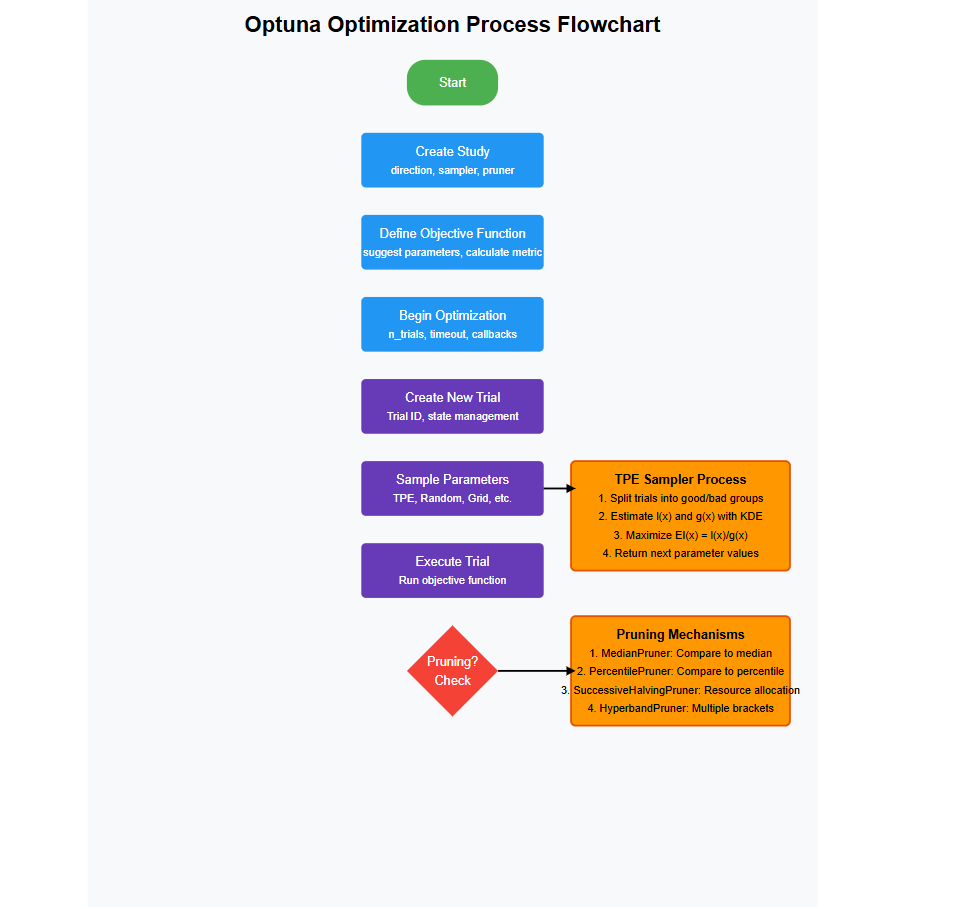

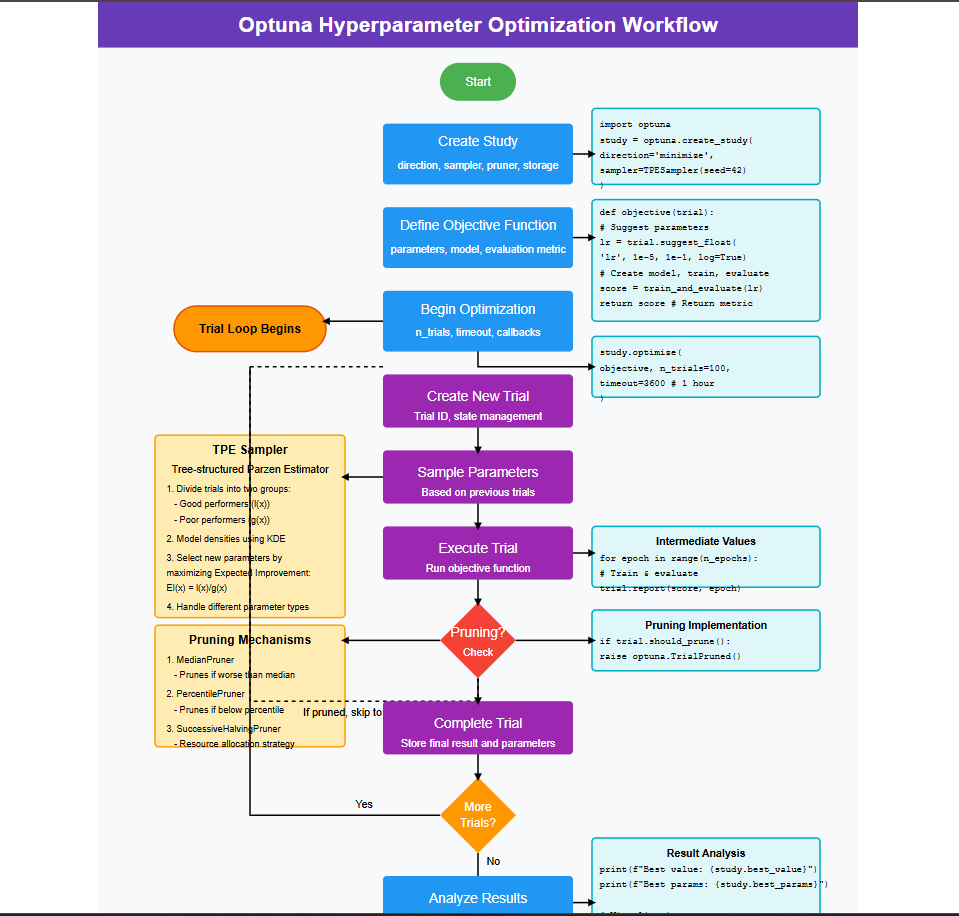

In [74]:
!pip install optuna

In [75]:
# Import necessary libraries
import optuna
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the Pima Indian Diabetes dataset from sklearn
# Note: Scikit-learn's built-in 'load_diabetes' is a regression dataset.
# We will load the actual diabetes dataset from an external source
import pandas as pd

# Load the Pima Indian Diabetes dataset (from UCI repository)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
           'DiabetesPedigreeFunction', 'Age', 'Outcome']

# Load the dataset
df = pd.read_csv(url, names=columns)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [76]:
import numpy as np

# Replace zero values with NaN in columns where zero is not a valid value
cols_with_missing_vals = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_missing_vals] = df[cols_with_missing_vals].replace(0, np.nan)

# Impute the missing values with the mean of the respective column
df.fillna(df.mean(), inplace=True)

# Check if there are any remaining missing values
print(df.isnull().sum())


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [77]:
# Split into features (X) and target (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optional: Scale the data for better model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shape of the data
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')


Training set shape: (537, 8)
Test set shape: (231, 8)


In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)

    # Create the RandomForestClassifier with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    # Perform 3-fold cross-validation and calculate accuracy
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()

    return score  # Return the accuracy score for Optuna to maximize


In [79]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials to find the best hyperparameters


[I 2025-03-30 21:08:32,032] A new study created in memory with name: no-name-8b5cfaee-adcb-40be-907d-2aab3dd5a5af
[I 2025-03-30 21:08:34,811] Trial 0 finished with value: 0.7690875232774674 and parameters: {'n_estimators': 156, 'max_depth': 10}. Best is trial 0 with value: 0.7690875232774674.
[I 2025-03-30 21:08:36,737] Trial 1 finished with value: 0.7709497206703911 and parameters: {'n_estimators': 192, 'max_depth': 19}. Best is trial 1 with value: 0.7709497206703911.
[I 2025-03-30 21:08:38,002] Trial 2 finished with value: 0.7672253258845437 and parameters: {'n_estimators': 94, 'max_depth': 4}. Best is trial 1 with value: 0.7709497206703911.
[I 2025-03-30 21:08:39,033] Trial 3 finished with value: 0.7728119180633147 and parameters: {'n_estimators': 74, 'max_depth': 7}. Best is trial 3 with value: 0.7728119180633147.
[I 2025-03-30 21:08:40,196] Trial 4 finished with value: 0.7690875232774674 and parameters: {'n_estimators': 185, 'max_depth': 14}. Best is trial 3 with value: 0.77281191

In [80]:

# Print the best result
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.7802607076350093
Best hyperparameters: {'n_estimators': 125, 'max_depth': 16}


In [81]:
from sklearn.metrics import accuracy_score

# Train a RandomForestClassifier using the best hyperparameters from Optuna
best_model = RandomForestClassifier(**study.best_trial.params, random_state=42)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print the test accuracy
print(f'Test Accuracy with best hyperparameters: {test_accuracy:.2f}')


Test Accuracy with best hyperparameters: 0.74


## Samplers in Optuna

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)

    # Create the RandomForestClassifier with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    # Perform 3-fold cross-validation and calculate accuracy
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()

    return score  # Return the accuracy score for Optuna to maximize


In [12]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials to find the best hyperparameters

[I 2025-03-30 20:07:14,603] A new study created in memory with name: no-name-a0f6da3f-37b3-43d4-beab-7a09bb653f7b
[I 2025-03-30 20:07:15,537] Trial 0 finished with value: 0.7635009310986964 and parameters: {'n_estimators': 147, 'max_depth': 8}. Best is trial 0 with value: 0.7635009310986964.
[I 2025-03-30 20:07:16,209] Trial 1 finished with value: 0.7728119180633147 and parameters: {'n_estimators': 112, 'max_depth': 7}. Best is trial 1 with value: 0.7728119180633147.
[I 2025-03-30 20:07:16,555] Trial 2 finished with value: 0.7523277467411545 and parameters: {'n_estimators': 62, 'max_depth': 3}. Best is trial 1 with value: 0.7728119180633147.
[I 2025-03-30 20:07:17,696] Trial 3 finished with value: 0.7728119180633147 and parameters: {'n_estimators': 191, 'max_depth': 13}. Best is trial 1 with value: 0.7728119180633147.
[I 2025-03-30 20:07:18,286] Trial 4 finished with value: 0.7672253258845437 and parameters: {'n_estimators': 96, 'max_depth': 13}. Best is trial 1 with value: 0.772811918

In [13]:

# Print the best result
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.7802607076350093
Best hyperparameters: {'n_estimators': 115, 'max_depth': 16}


In [14]:
from sklearn.metrics import accuracy_score

# Train a RandomForestClassifier using the best hyperparameters from Optuna
best_model = RandomForestClassifier(**study.best_trial.params, random_state=42)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print the test accuracy
print(f'Test Accuracy with best hyperparameters: {test_accuracy:.2f}')


Test Accuracy with best hyperparameters: 0.74


In [15]:
search_space = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20]
}

In [16]:
# Create a study and optimize it using GridSampler
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective)

[I 2025-03-30 20:08:37,952] A new study created in memory with name: no-name-2024b0b2-ff43-46e9-b4a4-213f98f34f7e
[I 2025-03-30 20:08:38,520] Trial 0 finished with value: 0.7690875232774674 and parameters: {'n_estimators': 100, 'max_depth': 5}. Best is trial 0 with value: 0.7690875232774674.
[I 2025-03-30 20:08:39,396] Trial 1 finished with value: 0.7672253258845437 and parameters: {'n_estimators': 150, 'max_depth': 10}. Best is trial 0 with value: 0.7690875232774674.
[I 2025-03-30 20:08:39,712] Trial 2 finished with value: 0.7728119180633147 and parameters: {'n_estimators': 50, 'max_depth': 15}. Best is trial 2 with value: 0.7728119180633147.
[I 2025-03-30 20:08:40,296] Trial 3 finished with value: 0.7653631284916201 and parameters: {'n_estimators': 100, 'max_depth': 15}. Best is trial 2 with value: 0.7728119180633147.
[I 2025-03-30 20:08:40,881] Trial 4 finished with value: 0.7690875232774674 and parameters: {'n_estimators': 100, 'max_depth': 20}. Best is trial 2 with value: 0.772811

In [17]:

# Print the best result
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.7746741154562384
Best hyperparameters: {'n_estimators': 50, 'max_depth': 5}


In [18]:
from sklearn.metrics import accuracy_score

# Train a RandomForestClassifier using the best hyperparameters from Optuna
best_model = RandomForestClassifier(**study.best_trial.params, random_state=42)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print the test accuracy
print(f'Test Accuracy with best hyperparameters: {test_accuracy:.2f}')


Test Accuracy with best hyperparameters: 0.74


## Optuna Visualizations

# Comprehensive Guide to Optuna Visualization

## Introduction
Optuna is a powerful hyperparameter optimization framework that provides various visualization tools to help understand the optimization process and results. This guide focuses on optimizing a Random Forest classifier with two key hyperparameters: `n_estimators` and `max_depth`.

## Setup for Visualization Examples
To generate these plots, you would typically:

1. Define your objective function for Random Forest optimization
2. Run multiple trials using Optuna
3. Visualize the results using Optuna's plotting functions

```python
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

# Sample data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Define objective function
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    
    clf = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=max_depth,
                                random_state=42)
    
    return cross_val_score(clf, X, y, cv=5).mean()

# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
```

## 1. Optimization History Plot

**What it shows:**
This plot displays the objective value (e.g., accuracy) for each trial against the trial number.

**Code:**
```python
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)
```

**Visual Description:**
- X-axis: Trial number (1 to 100)
- Y-axis: Objective value (accuracy in this case, typically between 0.7-0.95 for a decent Random Forest)
- Blue dots: Individual trials
- Blue line: Best value found up to each trial

**Knowledge Extraction:**
- You can see if optimization is still improving or has plateaued
- Initial trials often show high variance in performance
- As trials progress, you should see an upward trend that eventually flattens, indicating convergence
- For Random Forest, you might notice rapid initial improvement as the algorithm finds better combinations of n_estimators and max_depth, then diminishing returns

**Practical Insights:**
- If the line hasn't flattened, you might benefit from more trials
- Sudden jumps indicate breakthrough parameter combinations
- For Random Forest, you might see a jump when finding the "sweet spot" of n_estimators that balances bias and variance

## 2. Parallel Coordinate Plot

**What it shows:**
Multiple parallel axes, one for each hyperparameter and one for the objective value, with lines connecting values from each trial.

**Code:**
```python
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study, params=['n_estimators', 'max_depth'])
```

**Visual Description:**
- Three vertical parallel axes: n_estimators (10-200), max_depth (2-32), and accuracy (0.7-0.95)
- Colored lines: Each line represents a trial, with color indicating performance (darker/purple for better results)
- Line paths: Show parameter combinations for each trial

**Knowledge Extraction:**
- Reveals parameter interactions at a glance
- Shows clusters of good parameter combinations
- You might notice that higher performance (darker lines) often corresponds to specific ranges of both n_estimators and max_depth

**Practical Insights:**
- For Random Forest, you might observe:
  - Medium-to-high n_estimators (80-150) combined with medium max_depth (10-20) often yield best results
  - Very low max_depth limits model performance regardless of n_estimators
  - Very high n_estimators might not always improve performance if max_depth is suboptimal

## 3. Contour Plot

**What it shows:**
A 2D heatmap showing how different combinations of two parameters affect the objective value.

**Code:**
```python
from optuna.visualization import plot_contour
plot_contour(study, params=['n_estimators', 'max_depth'])
```

**Visual Description:**
- X-axis: n_estimators (10-200)
- Y-axis: max_depth (2-32)
- Color gradient: Blue/green for lower performance, yellow/red for higher performance
- Contour lines: Connect points of equal performance

**Knowledge Extraction:**
- Directly visualizes the parameter space landscape
- Reveals "valleys" and "peaks" of model performance
- Clearly shows optimal parameter regions

**Practical Insights:**
- For Random Forest, typical observations include:
  - "Performance plateau" after certain n_estimators threshold (often 80-100 trees)
  - Optimal max_depth often in mid-range (not too shallow, not too deep)
  - "Performance cliff" where too small max_depth severely limits model
  - Possible diminishing returns or even performance degradation with very high values of both parameters

## 4. Slice Plot

**What it shows:**
The relationship between individual parameter values and the objective, while holding other parameters constant.

**Code:**
```python
from optuna.visualization import plot_slice
plot_slice(study, params=['n_estimators', 'max_depth'])
```

**Visual Description:**
- Two separate plots side by side
- Each plot shows:
  - X-axis: Parameter value (n_estimators 10-200 or max_depth 2-32)
  - Y-axis: Objective value (accuracy)
  - Blue dots: Individual trials
  - Sorted by ascending parameter value

**Knowledge Extraction:**
- Reveals the marginal effect of each parameter
- Shows if parameter impact is linear, logarithmic, or has a clear optimum

**Practical Insights:**
- For n_estimators: Typically shows rapid improvement up to a point (50-100), then diminishing returns
- For max_depth: Often shows improvement up to a medium value (10-20), then plateau or slight decrease (indicating overfitting)
- Helps identify parameter thresholds beyond which improvements are minimal

## 5. Parameter Importance Plot

**What it shows:**
Relative importance of each hyperparameter in affecting the objective value.

**Code:**
```python
from optuna.visualization import plot_param_importances
plot_param_importances(study)
```

**Visual Description:**
- X-axis: Importance score (0-1)
- Y-axis: Parameter names (n_estimators, max_depth)
- Horizontal bars: Length represents relative importance
- Often sorted with most important parameter at top

**Knowledge Extraction:**
- Immediately identifies which parameters matter most
- Helps focus tuning efforts on high-impact parameters

**Practical Insights:**
- For Random Forest, max_depth often has higher importance than n_estimators
- Helps you understand which parameter to fine-tune first
- If importance is highly skewed, you might consider fixing the less important parameter

## 6. EDF (Empirical Distribution Function) Plot

**What it shows:**
The cumulative distribution of objective values across all trials.

**Code:**
```python
from optuna.visualization import plot_edf
plot_edf(study)
```

**Visual Description:**
- X-axis: Objective value (accuracy)
- Y-axis: Cumulative probability (0-1)
- S-shaped curve: Shows distribution of performance across trials

**Knowledge Extraction:**
- Provides statistical perspective on optimization results
- Shows the range and probability of different performance levels

**Practical Insights:**
- Steep sections indicate common performance ranges
- Flat sections indicate performance gaps
- For Random Forest, might show that most configurations achieve 0.8-0.85 accuracy, with fewer reaching 0.9+
- Helps set realistic expectations for model performance

## 7. Intermediate Values Plot

**What it shows:**
The evolution of performance during training for each trial (requires pruner and recording intermediate values).

**Code:**
```python
# Modified objective function to report intermediate values
def objective_with_intermediate(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    
    # Use warm_start to evaluate intermediate performance
    clf = RandomForestClassifier(max_depth=max_depth, random_state=42, warm_start=True)
    
    # Evaluate at different n_estimators stages
    step_size = max(1, n_estimators // 10)
    for n in range(step_size, n_estimators + 1, step_size):
        clf.n_estimators = n
        clf.fit(X_train, y_train)
        intermediate_value = clf.score(X_val, y_val)
        trial.report(intermediate_value, n)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return clf.score(X_val, y_val)

# Then after running study with this objective:
from optuna.visualization import plot_intermediate_values
plot_intermediate_values(study)
```

**Visual Description:**
- X-axis: Step (growing number of trees)
- Y-axis: Intermediate objective value (accuracy)
- Multiple colored lines: Each line represents a trial's performance evolution
- Line styles may differ based on parameter values

**Knowledge Extraction:**
- Shows learning curves for different parameter combinations
- Reveals how quickly models converge

**Practical Insights:**
- For Random Forest:
  - Helps identify optimal n_estimators by showing where performance plateaus
  - Trials with higher max_depth might show faster initial improvement but potentially overfit later
  - Helps balance computational resources against performance gains
  - Illustrates the law of diminishing returns for ensemble size

## Conclusion

Together, these visualization tools provide comprehensive insights into hyperparameter optimization for Random Forest classifiers. They help identify optimal parameter ranges, understand parameter interactions, focus tuning efforts, and set realistic performance expectations.

Most valuable plots for Random Forest with n_estimators and max_depth:
1. Contour Plot - Directly shows optimal regions in your 2D parameter space
2. Slice Plot - Shows exact thresholds where adding more trees stops being beneficial
3. Parameter Importance - Helps prioritize which parameter to fine-tune first

In [82]:
# For visualizations
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_contour, plot_param_importances, plot_edf

In [83]:
# 1. Optimization History
plot_optimization_history(study).show()

In [84]:
# 2. Parallel Coordinates Plot
plot_parallel_coordinate(study).show()

In [85]:
# 3. Slice Plot
plot_slice(study).show()

In [86]:
# 4. Contour Plot
plot_contour(study).show()

In [87]:
# 5. Hyperparameter Importance
plot_param_importances(study).show()

In [88]:
# 6. EDF (Empirical Distribution Function) Plot
plot_edf(study).show()

## Optimizing Multiple ML Models

### **Define-by-Run & Dynamic Search Spaces in Optuna: Explanation, Use Cases, and Implementation**

#### **1. What is "Define-by-Run"?**
**Define-by-run** is an API design paradigm where the hyperparameter search space is constructed **dynamically during the optimization process** (i.e., as the code runs). This contrasts with **define-and-run** frameworks (e.g., Hyperopt), where the search space must be statically predefined before optimization begins.

**Key Idea**:  
- Hyperparameters are defined *on-the-fly* within the objective function.  
- The structure of the search space can change dynamically based on decisions made in earlier steps of a trial.

---

#### **2. Dynamic Search Space Creation**
This allows the hyperparameter space to **adapt conditionally** based on choices made during a trial. For example:
- If a trial selects a neural network with 3 layers, parameters for all 3 layers are generated.  
- If another trial selects a decision tree, only tree-specific parameters (e.g., `max_depth`) are considered.  

---

#### **3. Why is This Useful?**
1. **Handles Conditional Parameters**:  
   - Parameters can depend on prior choices (e.g., layer count → layer-specific hyperparameters).  
   - Avoids defining unused parameters, reducing redundancy.  

2. **Supports Complex Models**:  
   - Ideal for neural networks, ensembles, or pipelines where parameters are hierarchical.  

3. **Efficiency**:  
   - Focuses computational resources only on relevant parts of the search space.  

4. **Flexibility**:  
   - Enables creative parameter interactions (e.g., adaptive architectures).  

---

#### **4. Implementation in Optuna**
**Step 1**: Define the objective function using the `trial` object to suggest parameters dynamically.  
**Step 2**: Use Python logic (loops, conditionals) to create parameters based on prior choices.

##### **Example 1: Dynamic Neural Network Layers**
```python
import optuna

def objective(trial):
    # Dynamically choose the number of layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    
    layers = []
    for i in range(n_layers):
        # Dynamically suggest units for each layer
        units = trial.suggest_int(f"units_layer_{i}", 32, 256)
        layers.append(units)
    
    # Train model and return validation loss
    validation_loss = train_model(layers)
    return validation_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
```

##### **Example 2: Model Selection with Conditional Parameters**
```python
def objective(trial):
    # Choose model type dynamically
    model_type = trial.suggest_categorical("model_type", ["svm", "random_forest"])
    
    if model_type == "svm":
        C = trial.suggest_float("C", 1e-5, 1e2, log=True)
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
        # Train SVM...
    else:
        max_depth = trial.suggest_int("max_depth", 2, 32)
        n_estimators = trial.suggest_int("n_estimators", 50, 200)
        # Train Random Forest...
    
    return validation_loss
```

---

#### **5. Key Advantages Over Static Search Spaces**
| **Feature**               | **Define-by-Run (Optuna)**              | **Define-and-Run (e.g., Hyperopt)**      |  
|---------------------------|-----------------------------------------|------------------------------------------|  
| **Parameter Dependencies** | Handles conditional parameters naturally | Requires predefining all possibilities |  
| **Code Readability**       | Uses native Python logic (loops/ifs)    | Relies on declarative configurations    |  
| **Flexibility**            | Adapts to complex workflows             | Limited to static search spaces         |  

---

#### **6. Practical Use Cases**
1. **Neural Architecture Search (NAS)**:  
   - Dynamically adjust network depth/width based on trial results.  
2. **Pipeline Optimization**:  
   - Conditionally include/exclude preprocessing steps.  
3. **Ensemble Models**:  
   - Vary the number of base learners or their types (e.g., mix SVMs and trees).  

---

#### **7. Best Practices**
- **Use Python Control Flow**: Loops (`for`/`while`) and conditionals (`if`/`else`) to build dynamic spaces.  
- **Avoid Overcomplication**: Keep the objective function readable; split logic into helper functions if needed.  
- **Leverage Logging**: Use `trial.set_user_attr()` to track dynamic choices (e.g., layer counts).  

---

#### **8. When to Use Define-by-Run?**
- Your hyperparameters have **hierarchical dependencies** (e.g., layer count → layer size).  
- The search space is **too large or complex** to predefine statically.  
- You need to **conditionally exclude parameters** based on model choices.  

---

### **Summary**
- **Define-by-run** and **dynamic search spaces** in Optuna let you construct hyperparameters *during* optimization using native Python code.  
- This approach is **flexible**, **efficient**, and ideal for complex tasks like neural architecture search or conditional parameter tuning.  
- Implementation involves using `trial.suggest_*()` methods within loops/conditionals inside the objective function.  


In [89]:
# Importing the required libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [90]:
# Define the objective function for Optuna
def objective(trial):
    # Choose the algorithm to tune
    classifier_name = trial.suggest_categorical('classifier', ['SVM', 'RandomForest', 'GradientBoosting'])

    if classifier_name == 'SVM':
        # SVM hyperparameters
        c = trial.suggest_float('C', 0.1, 100, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

        model = SVC(C=c, kernel=kernel, gamma=gamma, random_state=42)

    elif classifier_name == 'RandomForest':
        # Random Forest hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42
        )

    elif classifier_name == 'GradientBoosting':
        # Gradient Boosting hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

    # Perform cross-validation and return the mean accuracy
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

In [91]:
# Create a study and optimize it using CmaEsSampler
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# study = optuna.create_study(
#     direction="maximize",
#     study_name="my_cmaes_study",  # Name your study here
#     sampler=optuna.samplers.CmaEsSampler(),  # Use CMA-ES sampler
#     storage="sqlite:///my_studies.db"  # Optional: Save to database (include if you want persistence)
# )


[I 2025-03-30 21:10:53,469] A new study created in memory with name: no-name-501bb5e4-381f-41d7-8e73-4ae7d20944b7
[I 2025-03-30 21:10:55,868] Trial 0 finished with value: 0.7281191806331471 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 190, 'learning_rate': 0.29834737362920627, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7281191806331471.
[I 2025-03-30 21:11:00,824] Trial 1 finished with value: 0.7523277467411545 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 273, 'learning_rate': 0.010158802026747168, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7523277467411545.
[I 2025-03-30 21:11:01,366] Trial 2 finished with value: 0.7653631284916201 and parameters: {'classifier': 'RandomForest', 'n_estimators': 93, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 2 with value: 0.7653631284916201.
[I 2025-03-3

In [92]:
# Retrieve the best trial
best_trial = study.best_trial
print("Best trial parameters:", best_trial.params)
print("Best trial accuracy:", best_trial.value)

Best trial parameters: {'classifier': 'SVM', 'C': 0.14100754179715047, 'kernel': 'linear', 'gamma': 'auto'}
Best trial accuracy: 0.7895716945996275


In [93]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_C,params_bootstrap,params_classifier,params_gamma,params_kernel,params_learning_rate,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
0,0,0.728119,2025-03-30 21:10:53.470999,2025-03-30 21:10:55.868062,0 days 00:00:02.397063,NaN,NaN,GradientBoosting,NaN,NaN,0.298347,20.0,8.0,8.0,190.0,COMPLETE
1,1,0.752328,2025-03-30 21:10:55.872082,2025-03-30 21:11:00.824130,0 days 00:00:04.952048,NaN,NaN,GradientBoosting,NaN,NaN,0.010159,19.0,5.0,4.0,273.0,COMPLETE
2,2,0.765363,2025-03-30 21:11:00.825402,2025-03-30 21:11:01.366036,0 days 00:00:00.540634,NaN,True,RandomForest,NaN,NaN,NaN,19.0,5.0,8.0,93.0,COMPLETE
3,3,0.750466,2025-03-30 21:11:01.367317,2025-03-30 21:11:01.400937,0 days 00:00:00.033620,0.140344,NaN,SVM,auto,rbf,NaN,NaN,NaN,NaN,NaN,COMPLETE
4,4,0.685289,2025-03-30 21:11:01.402139,2025-03-30 21:11:01.430914,0 days 00:00:00.028775,28.257729,NaN,SVM,scale,sigmoid,NaN,NaN,NaN,NaN,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.787709,2025-03-30 21:11:31.098211,2025-03-30 21:11:31.142121,0 days 00:00:00.043910,0.103313,NaN,SVM,auto,linear,NaN,NaN,NaN,NaN,NaN,COMPLETE
96,96,0.715084,2025-03-30 21:11:31.143302,2025-03-30 21:11:31.183704,0 days 00:00:00.040402,0.174184,NaN,SVM,auto,poly,NaN,NaN,NaN,NaN,NaN,COMPLETE
97,97,0.785847,2025-03-30 21:11:31.184786,2025-03-30 21:11:31.218210,0 days 00:00:00.033424,0.236871,NaN,SVM,auto,linear,NaN,NaN,NaN,NaN,NaN,COMPLETE
98,98,0.789572,2025-03-30 21:11:31.219316,2025-03-30 21:11:31.251818,0 days 00:00:00.032502,0.137323,NaN,SVM,scale,linear,NaN,NaN,NaN,NaN,NaN,COMPLETE


In [94]:
study.trials_dataframe()['params_classifier'].value_counts()

,count
params_classifier,
SVM,79
GradientBoosting,11
RandomForest,10


In [95]:
study.trials_dataframe().groupby('params_classifier')['value'].mean()

,value
params_classifier,
GradientBoosting,0.753005
RandomForest,0.765736
SVM,0.776395


In [96]:
# 1. Optimization History
plot_optimization_history(study).show()

In [97]:
# 3. Slice Plot
plot_slice(study).show()

In [98]:
# 5. Hyperparameter Importance
plot_param_importances(study).show()

In [99]:
!pip install optuna-integration[xgboost]

In [100]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import numpy as np

# Load the Iris dataset
X, y = load_iris(return_X_y=True)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for XGBoost
def objective(trial):
    # Hyperparameter search space
    param = {
        'verbosity': 0,
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',  # Ensure that the eval_metric is specified here
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'n_estimators': 300,
    }

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define a pruning callback based on evaluation metrics
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "eval-mlogloss")  # Match the metric name in the evals list

    # Train the model
    bst = xgb.train(
        param,
        dtrain,
        num_boost_round=300,
        evals=[(dtrain, "train"), (dtest, "eval")],  # Ensure the eval datasets and names are specified
        early_stopping_rounds=30,
        callbacks=[pruning_callback]
    )

    # Predict on the test set
    preds = bst.predict(dtest)
    best_preds = [int(np.argmax(line)) for line in preds]

    # Return accuracy as the objective value
    accuracy = accuracy_score(y_test, best_preds)
    return accuracy

# Create a study with pruning
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objective, n_trials=50)

# Output the best trial
print(f"Best trial: {study.best_trial.params}")
print(f"Best accuracy: {study.best_value}")


[I 2025-03-30 21:12:19,203] A new study created in memory with name: no-name-572f8235-a345-4eca-8aa8-ca5cef371098


[0]	train-mlogloss:1.00867	eval-mlogloss:1.00813
[1]	train-mlogloss:0.90729	eval-mlogloss:0.90278
[2]	train-mlogloss:0.81821	eval-mlogloss:0.81161
[3]	train-mlogloss:0.74069	eval-mlogloss:0.72992
[4]	train-mlogloss:0.67260	eval-mlogloss:0.65905
[5]	train-mlogloss:0.61258	eval-mlogloss:0.59499
[6]	train-mlogloss:0.56043	eval-mlogloss:0.54048
[7]	train-mlogloss:0.51359	eval-mlogloss:0.49074
[8]	train-mlogloss:0.47107	eval-mlogloss:0.44644
[9]	train-mlogloss:0.43479	eval-mlogloss:0.40860
[10]	train-mlogloss:0.40093	eval-mlogloss:0.37586
[11]	train-mlogloss:0.37024	eval-mlogloss:0.34374
[12]	train-mlogloss:0.35237	eval-mlogloss:0.32799
[13]	train-mlogloss:0.32730	eval-mlogloss:0.30084
[14]	train-mlogloss:0.30978	eval-mlogloss:0.28356
[15]	train-mlogloss:0.28933	eval-mlogloss:0.26164
[16]	train-mlogloss:0.27215	eval-mlogloss:0.24383
[17]	train-mlogloss:0.25769	eval-mlogloss:0.23050
[18]	train-mlogloss:0.24206	eval-mlogloss:0.21406
[19]	train-mlogloss:0.22998	eval-mlogloss:0.20273
[20]	train

[I 2025-03-30 21:12:22,782] Trial 0 finished with value: 1.0 and parameters: {'lambda': 1.5465731832533289e-06, 'alpha': 0.03334327061870263, 'eta': 0.08995582319092868, 'gamma': 4.186441679500477e-08, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.9316767373963246, 'colsample_bytree': 0.5687963374576996}. Best is trial 0 with value: 1.0.


[0]	train-mlogloss:0.77349	eval-mlogloss:0.74903
[1]	train-mlogloss:0.57584	eval-mlogloss:0.53820
[2]	train-mlogloss:0.44009	eval-mlogloss:0.39792
[3]	train-mlogloss:0.34728	eval-mlogloss:0.30463
[4]	train-mlogloss:0.28298	eval-mlogloss:0.23955
[5]	train-mlogloss:0.23848	eval-mlogloss:0.18902
[6]	train-mlogloss:0.20687	eval-mlogloss:0.15413
[7]	train-mlogloss:0.18884	eval-mlogloss:0.13287
[8]	train-mlogloss:0.18015	eval-mlogloss:0.12142
[9]	train-mlogloss:0.17506	eval-mlogloss:0.11425
[10]	train-mlogloss:0.17036	eval-mlogloss:0.10885
[11]	train-mlogloss:0.16741	eval-mlogloss:0.10376
[12]	train-mlogloss:0.16609	eval-mlogloss:0.10266
[13]	train-mlogloss:0.16430	eval-mlogloss:0.10026
[14]	train-mlogloss:0.16394	eval-mlogloss:0.10005
[15]	train-mlogloss:0.16346	eval-mlogloss:0.09965
[16]	train-mlogloss:0.16329	eval-mlogloss:0.09809
[17]	train-mlogloss:0.16277	eval-mlogloss:0.09790
[18]	train-mlogloss:0.16255	eval-mlogloss:0.09831
[19]	train-mlogloss:0.16216	eval-mlogloss:0.09815
[20]	train

[I 2025-03-30 21:12:28,999] Trial 1 finished with value: 1.0 and parameters: {'lambda': 0.03510568172869524, 'alpha': 0.001102493610937559, 'eta': 0.2774527219089467, 'gamma': 0.03904643728569197, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.8659386685369219, 'colsample_bytree': 0.8326276689201109}. Best is trial 0 with value: 1.0.


[0]	train-mlogloss:0.85444	eval-mlogloss:0.85400
[1]	train-mlogloss:0.68166	eval-mlogloss:0.66347
[2]	train-mlogloss:0.54822	eval-mlogloss:0.51623
[3]	train-mlogloss:0.44783	eval-mlogloss:0.40954
[4]	train-mlogloss:0.36637	eval-mlogloss:0.34393
[5]	train-mlogloss:0.30352	eval-mlogloss:0.27715
[6]	train-mlogloss:0.25516	eval-mlogloss:0.22560
[7]	train-mlogloss:0.21931	eval-mlogloss:0.18899
[8]	train-mlogloss:0.18817	eval-mlogloss:0.15870
[9]	train-mlogloss:0.16426	eval-mlogloss:0.13145
[10]	train-mlogloss:0.14129	eval-mlogloss:0.11363
[11]	train-mlogloss:0.12491	eval-mlogloss:0.09608
[12]	train-mlogloss:0.11018	eval-mlogloss:0.08923
[13]	train-mlogloss:0.09935	eval-mlogloss:0.07688
[14]	train-mlogloss:0.09000	eval-mlogloss:0.06558
[15]	train-mlogloss:0.08441	eval-mlogloss:0.05935
[16]	train-mlogloss:0.07903	eval-mlogloss:0.05404
[17]	train-mlogloss:0.07410	eval-mlogloss:0.04616
[18]	train-mlogloss:0.06834	eval-mlogloss:0.04144
[19]	train-mlogloss:0.06495	eval-mlogloss:0.03852
[20]	train

[I 2025-03-30 21:12:29,529] Trial 2 pruned. Trial was pruned at iteration 32.


[0]	train-mlogloss:1.02849	eval-mlogloss:1.02308
[1]	train-mlogloss:0.96514	eval-mlogloss:0.95645
[2]	train-mlogloss:0.90727	eval-mlogloss:0.89452
[3]	train-mlogloss:0.85221	eval-mlogloss:0.83851
[4]	train-mlogloss:0.80302	eval-mlogloss:0.78756
[5]	train-mlogloss:0.75718	eval-mlogloss:0.73873
[6]	train-mlogloss:0.71590	eval-mlogloss:0.69540
[7]	train-mlogloss:0.67794	eval-mlogloss:0.65633
[8]	train-mlogloss:0.64268	eval-mlogloss:0.61946
[9]	train-mlogloss:0.60936	eval-mlogloss:0.58288
[10]	train-mlogloss:0.57813	eval-mlogloss:0.54936
[11]	train-mlogloss:0.54952	eval-mlogloss:0.51914
[12]	train-mlogloss:0.52345	eval-mlogloss:0.49074
[13]	train-mlogloss:0.49821	eval-mlogloss:0.46394
[14]	train-mlogloss:0.47467	eval-mlogloss:0.44044
[15]	train-mlogloss:0.45252	eval-mlogloss:0.41668
[16]	train-mlogloss:0.43221	eval-mlogloss:0.39533
[17]	train-mlogloss:0.41241	eval-mlogloss:0.37461
[18]	train-mlogloss:0.39423	eval-mlogloss:0.35568
[19]	train-mlogloss:0.37746	eval-mlogloss:0.33829
[20]	train

[I 2025-03-30 21:12:41,010] Trial 3 finished with value: 1.0 and parameters: {'lambda': 1.2935989167415743e-07, 'alpha': 4.118103425536638e-05, 'eta': 0.05450564939685883, 'gamma': 3.295072364598139e-08, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.7663462927732996, 'colsample_bytree': 0.837395249666122}. Best is trial 0 with value: 1.0.


[0]	train-mlogloss:0.98545	eval-mlogloss:0.97680
[1]	train-mlogloss:0.89005	eval-mlogloss:0.87639


[I 2025-03-30 21:12:42,455] Trial 4 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.01143	eval-mlogloss:1.00985
[1]	train-mlogloss:0.90237	eval-mlogloss:0.89586


[I 2025-03-30 21:12:42,715] Trial 5 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.81364	eval-mlogloss:0.79405
[1]	train-mlogloss:0.67703	eval-mlogloss:0.63588
[2]	train-mlogloss:0.56218	eval-mlogloss:0.51840


[I 2025-03-30 21:12:42,902] Trial 6 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.08387	eval-mlogloss:1.08464
[1]	train-mlogloss:1.06640	eval-mlogloss:1.06406
[2]	train-mlogloss:1.04518	eval-mlogloss:1.04185
[3]	train-mlogloss:1.02127	eval-mlogloss:1.01714
[4]	train-mlogloss:0.99865	eval-mlogloss:0.99421
[5]	train-mlogloss:0.97535	eval-mlogloss:0.96878
[6]	train-mlogloss:0.95782	eval-mlogloss:0.95071
[7]	train-mlogloss:0.94090	eval-mlogloss:0.93332
[8]	train-mlogloss:0.92544	eval-mlogloss:0.91644
[9]	train-mlogloss:0.90941	eval-mlogloss:0.89939
[10]	train-mlogloss:0.89059	eval-mlogloss:0.87973
[11]	train-mlogloss:0.87128	eval-mlogloss:0.85979
[12]	train-mlogloss:0.85990	eval-mlogloss:0.84793
[13]	train-mlogloss:0.84191	eval-mlogloss:0.82825
[14]	train-mlogloss:0.83268	eval-mlogloss:0.81810
[15]	train-mlogloss:0.81734	eval-mlogloss:0.80281
[16]	train-mlogloss:0.80328	eval-mlogloss:0.78848
[17]	train-mlogloss:0.79170	eval-mlogloss:0.77661
[18]	train-mlogloss:0.77507	eval-mlogloss:0.75950
[19]	train-mlogloss:0.76255	eval-mlogloss:0.74609
[20]	train

[I 2025-03-30 21:12:48,546] Trial 7 finished with value: 1.0 and parameters: {'lambda': 0.001598506510935537, 'alpha': 0.028268755734521183, 'eta': 0.02054860449975008, 'gamma': 1.4092115418677516e-07, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.5029499940135551, 'colsample_bytree': 0.6428671229523231}. Best is trial 0 with value: 1.0.


[0]	train-mlogloss:1.08030	eval-mlogloss:1.07904
[1]	train-mlogloss:1.06258	eval-mlogloss:1.06094
[2]	train-mlogloss:1.04512	eval-mlogloss:1.04284
[3]	train-mlogloss:1.02795	eval-mlogloss:1.02542
[4]	train-mlogloss:1.01133	eval-mlogloss:1.00858
[5]	train-mlogloss:0.99499	eval-mlogloss:0.99154
[6]	train-mlogloss:0.97911	eval-mlogloss:0.97523
[7]	train-mlogloss:0.96374	eval-mlogloss:0.95950
[8]	train-mlogloss:0.94875	eval-mlogloss:0.94376
[9]	train-mlogloss:0.93407	eval-mlogloss:0.92839
[10]	train-mlogloss:0.91954	eval-mlogloss:0.91332
[11]	train-mlogloss:0.90528	eval-mlogloss:0.89843
[12]	train-mlogloss:0.89140	eval-mlogloss:0.88388
[13]	train-mlogloss:0.87792	eval-mlogloss:0.86983
[14]	train-mlogloss:0.86480	eval-mlogloss:0.85629
[15]	train-mlogloss:0.85189	eval-mlogloss:0.84284
[16]	train-mlogloss:0.83937	eval-mlogloss:0.82978
[17]	train-mlogloss:0.82697	eval-mlogloss:0.81720
[18]	train-mlogloss:0.81472	eval-mlogloss:0.80438
[19]	train-mlogloss:0.80272	eval-mlogloss:0.79176
[20]	train

[I 2025-03-30 21:12:51,951] Trial 8 pruned. Trial was pruned at iteration 128.


[0]	train-mlogloss:0.92681	eval-mlogloss:0.92736
[1]	train-mlogloss:0.76534	eval-mlogloss:0.73280


[I 2025-03-30 21:12:52,015] Trial 9 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.02882	eval-mlogloss:1.03305
[1]	train-mlogloss:0.87109	eval-mlogloss:0.86694


[I 2025-03-30 21:12:52,223] Trial 10 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.96019	eval-mlogloss:0.96261
[1]	train-mlogloss:0.80922	eval-mlogloss:0.80188
[2]	train-mlogloss:0.69005	eval-mlogloss:0.67663


[I 2025-03-30 21:12:52,449] Trial 11 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.86332	eval-mlogloss:0.84403
[1]	train-mlogloss:0.69342	eval-mlogloss:0.66822


[I 2025-03-30 21:12:52,600] Trial 12 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.83459	eval-mlogloss:0.83736
[1]	train-mlogloss:0.60358	eval-mlogloss:0.58955
[2]	train-mlogloss:0.45197	eval-mlogloss:0.43326


[I 2025-03-30 21:12:52,852] Trial 13 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.00103	eval-mlogloss:0.99884
[1]	train-mlogloss:0.89195	eval-mlogloss:0.88373


[I 2025-03-30 21:12:52,926] Trial 14 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.99550	eval-mlogloss:1.00561
[1]	train-mlogloss:0.78810	eval-mlogloss:0.78736
[2]	train-mlogloss:0.63597	eval-mlogloss:0.62615


[I 2025-03-30 21:12:53,018] Trial 15 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.94077	eval-mlogloss:0.92777
[1]	train-mlogloss:0.81447	eval-mlogloss:0.79935


[I 2025-03-30 21:12:53,502] Trial 16 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.04580	eval-mlogloss:1.04125
[1]	train-mlogloss:0.98039	eval-mlogloss:0.97339
[2]	train-mlogloss:0.91987	eval-mlogloss:0.90963
[3]	train-mlogloss:0.86335	eval-mlogloss:0.85282
[4]	train-mlogloss:0.81293	eval-mlogloss:0.80025
[5]	train-mlogloss:0.76429	eval-mlogloss:0.74873
[6]	train-mlogloss:0.72147	eval-mlogloss:0.70461
[7]	train-mlogloss:0.68272	eval-mlogloss:0.66483
[8]	train-mlogloss:0.64630	eval-mlogloss:0.62678


[I 2025-03-30 21:12:53,760] Trial 17 pruned. Trial was pruned at iteration 8.


[0]	train-mlogloss:0.88177	eval-mlogloss:0.88086
[1]	train-mlogloss:0.66343	eval-mlogloss:0.64715
[2]	train-mlogloss:0.51539	eval-mlogloss:0.49293


[I 2025-03-30 21:12:54,239] Trial 18 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.96799	eval-mlogloss:0.99556
[1]	train-mlogloss:0.73701	eval-mlogloss:0.75207
[2]	train-mlogloss:0.57678	eval-mlogloss:0.57765


[I 2025-03-30 21:12:54,343] Trial 19 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.76014	eval-mlogloss:0.73205
[1]	train-mlogloss:0.55592	eval-mlogloss:0.51241
[2]	train-mlogloss:0.41989	eval-mlogloss:0.37225


[I 2025-03-30 21:12:54,544] Trial 20 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.01981	eval-mlogloss:1.01334
[1]	train-mlogloss:0.94948	eval-mlogloss:0.93914
[2]	train-mlogloss:0.88552	eval-mlogloss:0.87088
[3]	train-mlogloss:0.82552	eval-mlogloss:0.80984
[4]	train-mlogloss:0.77246	eval-mlogloss:0.75489
[5]	train-mlogloss:0.72353	eval-mlogloss:0.70253
[6]	train-mlogloss:0.67981	eval-mlogloss:0.65701
[7]	train-mlogloss:0.63992	eval-mlogloss:0.61526


[I 2025-03-30 21:12:54,657] Trial 21 pruned. Trial was pruned at iteration 8.


[0]	train-mlogloss:1.02399	eval-mlogloss:1.01871
[1]	train-mlogloss:0.95684	eval-mlogloss:0.94781
[2]	train-mlogloss:0.89529	eval-mlogloss:0.88456
[3]	train-mlogloss:0.83864	eval-mlogloss:0.82655
[4]	train-mlogloss:0.78793	eval-mlogloss:0.77525
[5]	train-mlogloss:0.74056	eval-mlogloss:0.72416
[6]	train-mlogloss:0.69838	eval-mlogloss:0.68081
[7]	train-mlogloss:0.65934	eval-mlogloss:0.64064


[I 2025-03-30 21:12:54,865] Trial 22 pruned. Trial was pruned at iteration 8.


[0]	train-mlogloss:0.94784	eval-mlogloss:0.93777
[1]	train-mlogloss:0.82579	eval-mlogloss:0.80514


[I 2025-03-30 21:12:54,976] Trial 23 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.06501	eval-mlogloss:1.06474
[1]	train-mlogloss:1.01824	eval-mlogloss:1.01606
[2]	train-mlogloss:0.97402	eval-mlogloss:0.96992
[3]	train-mlogloss:0.93190	eval-mlogloss:0.92712
[4]	train-mlogloss:0.89286	eval-mlogloss:0.88719
[5]	train-mlogloss:0.85544	eval-mlogloss:0.84738
[6]	train-mlogloss:0.82114	eval-mlogloss:0.81214
[7]	train-mlogloss:0.78919	eval-mlogloss:0.77942
[8]	train-mlogloss:0.75884	eval-mlogloss:0.74691


[I 2025-03-30 21:12:55,157] Trial 24 pruned. Trial was pruned at iteration 8.


[0]	train-mlogloss:0.99639	eval-mlogloss:0.98905
[1]	train-mlogloss:0.90665	eval-mlogloss:0.89716
[2]	train-mlogloss:0.82788	eval-mlogloss:0.81552


[I 2025-03-30 21:12:55,270] Trial 25 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.93771	eval-mlogloss:0.94264
[1]	train-mlogloss:0.76461	eval-mlogloss:0.75951


[I 2025-03-30 21:12:55,368] Trial 26 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.94882	eval-mlogloss:0.93754
[1]	train-mlogloss:0.82850	eval-mlogloss:0.81066


[I 2025-03-30 21:12:55,505] Trial 27 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.06388	eval-mlogloss:1.06101
[1]	train-mlogloss:1.01999	eval-mlogloss:1.01551
[2]	train-mlogloss:0.97811	eval-mlogloss:0.97093
[3]	train-mlogloss:0.93785	eval-mlogloss:0.92995
[4]	train-mlogloss:0.90083	eval-mlogloss:0.89136
[5]	train-mlogloss:0.86454	eval-mlogloss:0.85363
[6]	train-mlogloss:0.83140	eval-mlogloss:0.82024
[7]	train-mlogloss:0.80055	eval-mlogloss:0.78882


[I 2025-03-30 21:12:55,696] Trial 28 pruned. Trial was pruned at iteration 8.


[0]	train-mlogloss:1.00287	eval-mlogloss:0.99482
[1]	train-mlogloss:0.91918	eval-mlogloss:0.90972


[I 2025-03-30 21:12:55,920] Trial 29 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.81996	eval-mlogloss:0.81323
[1]	train-mlogloss:0.63215	eval-mlogloss:0.63135
[2]	train-mlogloss:0.49670	eval-mlogloss:0.48684


[I 2025-03-30 21:12:56,585] Trial 30 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.08270	eval-mlogloss:1.08177
[1]	train-mlogloss:1.06716	eval-mlogloss:1.06397
[2]	train-mlogloss:1.05186	eval-mlogloss:1.04851
[3]	train-mlogloss:1.03080	eval-mlogloss:1.02635
[4]	train-mlogloss:1.01321	eval-mlogloss:1.00861
[5]	train-mlogloss:0.99564	eval-mlogloss:0.99005
[6]	train-mlogloss:0.97951	eval-mlogloss:0.97252
[7]	train-mlogloss:0.96686	eval-mlogloss:0.95995
[8]	train-mlogloss:0.95214	eval-mlogloss:0.94466
[9]	train-mlogloss:0.93646	eval-mlogloss:0.92841
[10]	train-mlogloss:0.92397	eval-mlogloss:0.91537
[11]	train-mlogloss:0.90874	eval-mlogloss:0.89980
[12]	train-mlogloss:0.89731	eval-mlogloss:0.88790
[13]	train-mlogloss:0.88633	eval-mlogloss:0.87685
[14]	train-mlogloss:0.87721	eval-mlogloss:0.86684
[15]	train-mlogloss:0.86451	eval-mlogloss:0.85367
[16]	train-mlogloss:0.85370	eval-mlogloss:0.84207
[17]	train-mlogloss:0.84200	eval-mlogloss:0.83013
[18]	train-mlogloss:0.82537	eval-mlogloss:0.81256
[19]	train-mlogloss:0.81318	eval-mlogloss:0.79943
[20]	train

[I 2025-03-30 21:13:01,935] Trial 31 finished with value: 1.0 and parameters: {'lambda': 0.0014732132444910642, 'alpha': 0.040750816370040695, 'eta': 0.019791372329776583, 'gamma': 1.1436690048340648e-07, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.44219353399854827, 'colsample_bytree': 0.6343781305368362}. Best is trial 0 with value: 1.0.


[0]	train-mlogloss:1.07396	eval-mlogloss:1.07385
[1]	train-mlogloss:1.04047	eval-mlogloss:1.03667
[2]	train-mlogloss:1.00512	eval-mlogloss:1.00067
[3]	train-mlogloss:0.96503	eval-mlogloss:0.95979
[4]	train-mlogloss:0.92939	eval-mlogloss:0.92275
[5]	train-mlogloss:0.89316	eval-mlogloss:0.88360
[6]	train-mlogloss:0.86147	eval-mlogloss:0.85220
[7]	train-mlogloss:0.83359	eval-mlogloss:0.82621
[8]	train-mlogloss:0.80527	eval-mlogloss:0.79534


[I 2025-03-30 21:13:02,743] Trial 32 pruned. Trial was pruned at iteration 8.


[0]	train-mlogloss:1.08941	eval-mlogloss:1.08804
[1]	train-mlogloss:1.07443	eval-mlogloss:1.07239
[2]	train-mlogloss:1.06116	eval-mlogloss:1.05859
[3]	train-mlogloss:1.04636	eval-mlogloss:1.04340
[4]	train-mlogloss:1.03226	eval-mlogloss:1.02874
[5]	train-mlogloss:1.01761	eval-mlogloss:1.01299
[6]	train-mlogloss:1.00658	eval-mlogloss:1.00137
[7]	train-mlogloss:0.99418	eval-mlogloss:0.98883
[8]	train-mlogloss:0.98105	eval-mlogloss:0.97486
[9]	train-mlogloss:0.96807	eval-mlogloss:0.96132
[10]	train-mlogloss:0.95564	eval-mlogloss:0.94810
[11]	train-mlogloss:0.94312	eval-mlogloss:0.93466
[12]	train-mlogloss:0.93547	eval-mlogloss:0.92745
[13]	train-mlogloss:0.92333	eval-mlogloss:0.91420
[14]	train-mlogloss:0.91589	eval-mlogloss:0.90668
[15]	train-mlogloss:0.90522	eval-mlogloss:0.89562
[16]	train-mlogloss:0.89567	eval-mlogloss:0.88586
[17]	train-mlogloss:0.88701	eval-mlogloss:0.87626
[18]	train-mlogloss:0.87681	eval-mlogloss:0.86630
[19]	train-mlogloss:0.86771	eval-mlogloss:0.85695
[20]	train

[I 2025-03-30 21:13:05,799] Trial 33 pruned. Trial was pruned at iteration 128.


[0]	train-mlogloss:1.06411	eval-mlogloss:1.06563
[1]	train-mlogloss:1.01872	eval-mlogloss:1.01478
[2]	train-mlogloss:0.96474	eval-mlogloss:0.95813
[3]	train-mlogloss:0.91309	eval-mlogloss:0.90546
[4]	train-mlogloss:0.86698	eval-mlogloss:0.85714
[5]	train-mlogloss:0.82203	eval-mlogloss:0.80867
[6]	train-mlogloss:0.78185	eval-mlogloss:0.76677
[7]	train-mlogloss:0.74780	eval-mlogloss:0.73503
[8]	train-mlogloss:0.71463	eval-mlogloss:0.69875


[I 2025-03-30 21:13:06,974] Trial 34 pruned. Trial was pruned at iteration 8.


[0]	train-mlogloss:1.02739	eval-mlogloss:1.02265
[1]	train-mlogloss:0.95599	eval-mlogloss:0.94137


[I 2025-03-30 21:13:07,214] Trial 35 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.03987	eval-mlogloss:1.03639
[1]	train-mlogloss:0.95694	eval-mlogloss:0.94996


[I 2025-03-30 21:13:08,129] Trial 36 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.88086	eval-mlogloss:0.86498
[1]	train-mlogloss:0.72257	eval-mlogloss:0.69529
[2]	train-mlogloss:0.59842	eval-mlogloss:0.56570


[I 2025-03-30 21:13:08,778] Trial 37 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.06666	eval-mlogloss:1.06392
[1]	train-mlogloss:1.03632	eval-mlogloss:1.03190
[2]	train-mlogloss:1.00676	eval-mlogloss:1.00120
[3]	train-mlogloss:0.97778	eval-mlogloss:0.97092
[4]	train-mlogloss:0.95110	eval-mlogloss:0.94317
[5]	train-mlogloss:0.92420	eval-mlogloss:0.91410
[6]	train-mlogloss:0.89927	eval-mlogloss:0.88778
[7]	train-mlogloss:0.87556	eval-mlogloss:0.86356


[I 2025-03-30 21:13:09,329] Trial 38 pruned. Trial was pruned at iteration 8.


[0]	train-mlogloss:0.96512	eval-mlogloss:0.95489
[1]	train-mlogloss:0.85347	eval-mlogloss:0.84060


[I 2025-03-30 21:13:09,501] Trial 39 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.92467	eval-mlogloss:0.91053
[1]	train-mlogloss:0.78982	eval-mlogloss:0.76424


[I 2025-03-30 21:13:09,715] Trial 40 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.09029	eval-mlogloss:1.09043
[1]	train-mlogloss:1.08236	eval-mlogloss:1.08101
[2]	train-mlogloss:1.07291	eval-mlogloss:1.07133
[3]	train-mlogloss:1.06405	eval-mlogloss:1.06279
[4]	train-mlogloss:1.05441	eval-mlogloss:1.05363
[5]	train-mlogloss:1.04298	eval-mlogloss:1.04146
[6]	train-mlogloss:1.03351	eval-mlogloss:1.03193
[7]	train-mlogloss:1.02538	eval-mlogloss:1.02442
[8]	train-mlogloss:1.01853	eval-mlogloss:1.01788
[9]	train-mlogloss:1.00886	eval-mlogloss:1.00820
[10]	train-mlogloss:1.00069	eval-mlogloss:1.00034
[11]	train-mlogloss:0.99097	eval-mlogloss:0.99021
[12]	train-mlogloss:0.98329	eval-mlogloss:0.98223
[13]	train-mlogloss:0.97649	eval-mlogloss:0.97543
[14]	train-mlogloss:0.97141	eval-mlogloss:0.97032
[15]	train-mlogloss:0.96329	eval-mlogloss:0.96224
[16]	train-mlogloss:0.95571	eval-mlogloss:0.95415
[17]	train-mlogloss:0.94898	eval-mlogloss:0.94661
[18]	train-mlogloss:0.93987	eval-mlogloss:0.93702
[19]	train-mlogloss:0.93317	eval-mlogloss:0.93026
[20]	train

[I 2025-03-30 21:13:11,091] Trial 41 finished with value: 0.9666666666666667 and parameters: {'lambda': 0.0015265322942115296, 'alpha': 0.061465955308220056, 'eta': 0.011748697588099759, 'gamma': 1.1889154976320467e-07, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.4040656433864585, 'colsample_bytree': 0.6403047770577899}. Best is trial 0 with value: 1.0.


[0]	train-mlogloss:1.07980	eval-mlogloss:1.07868
[1]	train-mlogloss:1.05953	eval-mlogloss:1.05553
[2]	train-mlogloss:1.03552	eval-mlogloss:1.03117
[3]	train-mlogloss:1.00862	eval-mlogloss:1.00368
[4]	train-mlogloss:0.98458	eval-mlogloss:0.97861
[5]	train-mlogloss:0.96020	eval-mlogloss:0.95282
[6]	train-mlogloss:0.93790	eval-mlogloss:0.92994
[7]	train-mlogloss:0.91748	eval-mlogloss:0.91105
[8]	train-mlogloss:0.89641	eval-mlogloss:0.88826


[I 2025-03-30 21:13:11,255] Trial 42 pruned. Trial was pruned at iteration 8.


[0]	train-mlogloss:1.06797	eval-mlogloss:1.06919
[1]	train-mlogloss:1.03645	eval-mlogloss:1.03193
[2]	train-mlogloss:1.00288	eval-mlogloss:0.99750
[3]	train-mlogloss:0.95984	eval-mlogloss:0.95394
[4]	train-mlogloss:0.92437	eval-mlogloss:0.91722
[5]	train-mlogloss:0.89002	eval-mlogloss:0.88055
[6]	train-mlogloss:0.85817	eval-mlogloss:0.84739
[7]	train-mlogloss:0.83334	eval-mlogloss:0.82261
[8]	train-mlogloss:0.80662	eval-mlogloss:0.79574


[I 2025-03-30 21:13:11,373] Trial 43 pruned. Trial was pruned at iteration 8.


[0]	train-mlogloss:1.03565	eval-mlogloss:1.03539
[1]	train-mlogloss:0.95507	eval-mlogloss:0.94551
[2]	train-mlogloss:0.86848	eval-mlogloss:0.85361


[I 2025-03-30 21:13:11,460] Trial 44 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.08561	eval-mlogloss:1.08605
[1]	train-mlogloss:1.07147	eval-mlogloss:1.07149
[2]	train-mlogloss:1.05550	eval-mlogloss:1.05426
[3]	train-mlogloss:1.04823	eval-mlogloss:1.04650
[4]	train-mlogloss:1.03210	eval-mlogloss:1.03068
[5]	train-mlogloss:1.01476	eval-mlogloss:1.01279
[6]	train-mlogloss:0.99499	eval-mlogloss:0.99262
[7]	train-mlogloss:0.98609	eval-mlogloss:0.98312
[8]	train-mlogloss:0.97661	eval-mlogloss:0.97351
[9]	train-mlogloss:0.95983	eval-mlogloss:0.95562
[10]	train-mlogloss:0.94688	eval-mlogloss:0.94244
[11]	train-mlogloss:0.93220	eval-mlogloss:0.92741
[12]	train-mlogloss:0.92473	eval-mlogloss:0.91929
[13]	train-mlogloss:0.91209	eval-mlogloss:0.90557
[14]	train-mlogloss:0.90602	eval-mlogloss:0.89828
[15]	train-mlogloss:0.89755	eval-mlogloss:0.89022
[16]	train-mlogloss:0.88473	eval-mlogloss:0.87634
[17]	train-mlogloss:0.87383	eval-mlogloss:0.86394
[18]	train-mlogloss:0.86812	eval-mlogloss:0.85859
[19]	train-mlogloss:0.86281	eval-mlogloss:0.85311
[20]	train

[I 2025-03-30 21:13:13,102] Trial 45 finished with value: 0.9666666666666667 and parameters: {'lambda': 0.19834997439025379, 'alpha': 0.10087302569117503, 'eta': 0.027066271396407764, 'gamma': 1.778301696893149e-08, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.446571175681593, 'colsample_bytree': 0.4433529775085292}. Best is trial 0 with value: 1.0.


[0]	train-mlogloss:1.04500	eval-mlogloss:1.04204
[1]	train-mlogloss:0.99067	eval-mlogloss:0.97964
[2]	train-mlogloss:0.92039	eval-mlogloss:0.90363


[I 2025-03-30 21:13:13,264] Trial 46 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.05710	eval-mlogloss:1.06197
[1]	train-mlogloss:1.00453	eval-mlogloss:1.00595


[I 2025-03-30 21:13:13,416] Trial 47 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:0.86370	eval-mlogloss:0.86225
[1]	train-mlogloss:0.63747	eval-mlogloss:0.62300


[I 2025-03-30 21:13:13,547] Trial 48 pruned. Trial was pruned at iteration 2.


[0]	train-mlogloss:1.03558	eval-mlogloss:1.03180
[1]	train-mlogloss:0.97811	eval-mlogloss:0.97120
[2]	train-mlogloss:0.92482	eval-mlogloss:0.91587


[I 2025-03-30 21:13:13,633] Trial 49 pruned. Trial was pruned at iteration 2.


Best trial: {'lambda': 1.5465731832533289e-06, 'alpha': 0.03334327061870263, 'eta': 0.08995582319092868, 'gamma': 4.186441679500477e-08, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.9316767373963246, 'colsample_bytree': 0.5687963374576996}
Best accuracy: 1.0


In [101]:
from optuna.visualization import plot_intermediate_values

# 1. Plot intermediate values during the trials
plot_intermediate_values(study).show()